# RL preliminaries

In [192]:

import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import os
from datetime import datetime
import pandas as pd
import pickle as pkl
pd.options.mode.chained_assignment = None 
# from inspect import getsource
from recogym.evaluate_agent_sale import verify_agents_sale, display_metrics, verify_agents_sale_extended 
from tqdm import tqdm

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.agents.sale_agent import train_agents, train_timeagents
from recogym.envs.utils_sale import format_avg_result, avg_result, format_avg_result_extended, avg_result_extended


# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 0
env_1_sale_args['num_products'] = 10
env_1_sale_args['number_of_flips'] = 10 

num_products = env_1_sale_args['num_products']
print('Number of products =',num_products)
print('Number of flips =',env_1_sale_args['number_of_flips'])
nb_flips = env_1_sale_args['number_of_flips']

# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42
env_1_sale_args['mu_sale'] = False 

# env_1_sale_args['kappa'] = 0.5
print('Value of kappa =',env_1_sale_args['kappa'])

# Initialize the gym 
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)



Number of products = 10
Number of flips = 10
Value of kappa = 0.2


In [193]:
from recogym.agents.sale_agent_repeated import PseudoRewards, ShareViewsCountClicksFeatureProvider

# Define pseudo rewards
data = logs[name_agent]
RewardTilde = PseudoRewards(clicks_only=False)

# Define user features
UserFeatures = ShareViewsCountClicksFeatureProvider(config = env.config )
UserFeatures.reset()

### Simulator rewards, online

In [194]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import itertools
import seaborn as sns
from recogym.agents.sale_agent_reinforce import Model, make_seed, REINFORCE 
# from recogym.agents.sale_agent_reinforce import Model, make_seed, REINFORCE,PseudoREINFORCE

learning_rate = 0.014
gamma = .98
seed = 1235

config = {**env_1_sale_args,
    'learning_rate': learning_rate,
    'seed': env_1_sale_args['random_seed'],
    'gamma': gamma
}

print("Config : ",config)


Config :  {'learning_rate': 0.014, 'seed': 42, 'gamma': 0.98}


In [195]:
class PseudoREINFORCE(REINFORCE):
        
    def __init__(self, config, env, user_features, pseudo_reward_provider):
        super().__init__(config, env, user_features)
        self.pseudo_reward_provider = pseudo_reward_provider
        # sanity checks
        self.reward_list = []
        self.pseudo_reward_list = []
        self.true_rewards = []
    
    def _compute_pseudo_returns(self, rewards, pseudo_rewards):
        num_rew = len(rewards)
        future_rewards = []
        for i in range(num_rew):
            # the reward we consider are the reward at time i, and then the pseudo rewards
            R = np.array([rewards[i]]+pseudo_rewards[(i+1):])
            # the cumulative rewards at time i are discounted by gamma^{i},gamma^{i+1},gamma^{i+2}, etc.
            # however the discounts applied when computing the returns are : gamma^{0},gamma^{1},gamma^{2}, etc.
            R = (self.gamma**i)*R
            sum_future_rewards = self._compute_returns(R)
            sum_future_rewards = np.sum(sum_future_rewards)
            future_rewards.append(sum_future_rewards)
        future_rewards = np.array(future_rewards)
        return future_rewards
    
        
    def optimize_model(self, n_trajectories):

        reward_trajectories = np.empty(n_trajectories)
        true_reward_trajectories = np.empty(n_trajectories)
        loss = 0.
        
        for i in range(n_trajectories):
#             print('trajectory nb'+str(i))
#             print(datetime.now())
            traj_rewards = []  # rewards of the trajectory
            traj_pseudo_rewards = []  # pseudo rewards of the trajectory
#             traj_proba = 0.  # sum of log-probabilities of trajectory
            traj_proba = []  # list of log-probabilities of trajectory
            
            # Build trajectory
            done = False
            self.env.reset()
            # reset user features
            self.reset()
            obs_raw, _, done, reward = self.env.step(None)
            log = self.observation_to_log(obs_raw,reward)
            self.user_features.observe(log, memory=False)
            state = self.user_features.features()
            state = torch.from_numpy(state).float()
            
            while not done:
                action = self.model.select_action(state)  # can be cast to int for action idx
                # Get proba
                prob = self.model(state)[int(action)]
#                 traj_proba += torch.log(prob)
                traj_proba += [torch.log(prob)]
                
                obs_raw, reward, done, info = self.env.step(int(action))
                log = self.observation_to_log(obs_raw,reward)
                true_reward_trajectories[i] += sum(log['z']=='sale')
                self.user_features.observe(log, memory=False)
                state = self.user_features.features()
                state = torch.from_numpy(state).float()

                self.pseudo_reward_provider.pseudo_observe(log)
                pseudo_reward = self.pseudo_reward_provider.data_rewards
                immediate_sale = int(pseudo_reward['immediate_sale'])
                pseudo_reward = int(pseudo_reward['pseudo_y'])
                    
                # Store the new reward
                traj_rewards.append(reward)
                traj_pseudo_rewards.append(pseudo_reward)
            self.reward_list.append(traj_rewards)
            self.pseudo_reward_list.append(traj_pseudo_rewards)
            traj_pseudo_rewards = np.array(traj_pseudo_rewards)
#             traj_proba = torch.tensor(traj_proba)
            traj_proba = torch.tensor(traj_proba,requires_grad=True).double()
            
            # Get total reward
            total_reward = torch.from_numpy(self._compute_pseudo_returns(traj_rewards, traj_pseudo_rewards)).double()
    
            reward_trajectories[i] = np.sum(traj_rewards) 
#             loss = loss + total_reward * traj_proba / n_trajectories  # accumulate the negative criterion
            # NB : average over trajectories and not average reward during the episode !
#             print('traj proba',traj_proba)
            loss = loss + torch.dot(traj_proba,total_reward) / n_trajectories  # accumulate the negative criterion
#             print("Loss end traj : ",loss)
            # reset user features construction and delete logs in memory
            self.reset()
            
        self.env.close()  # important
        
        loss = -loss
        
        # The following lines take care of the gradient descent step for the variable loss
        # that you need to compute.
        print("Loss:", loss.data.numpy())
        
        # Discard previous gradients
        self.optimizer.zero_grad()
        # Compute the gradient 
        loss.backward()
        # Do the gradient descent step
        self.optimizer.step()
        return reward_trajectories, true_reward_trajectories
    
    def train(self, n_trajectories, n_update):
        """Training method
prin
        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expected gradient
        n_update : int
            The number of gradient updates
            
        """
        
        final_update = self.current_ep + n_update
        rewards = self.rewards  # initialize the reward record
        true_rewards = self.true_rewards
        plot_res = False if len(rewards)>0 else True
        
        for episode in range(self.current_ep, final_update):
            rew, true_rew = self.optimize_model(n_trajectories)
            rewards.append(rew)
            true_rewards.append(true_rew)
            print(f'\nEpisode {episode + 1}/{final_update}:')
            print('------ Attributed metrics')
            print(f'- Average attributed sales {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')
            print(f'- Total attributed sales {round(rewards[-1].sum(), 2)}')
            print(f'- Attributed CR {round(np.mean(np.array(rewards[-1])>0),4)}')

            print('------ True metrics')
            print(f'- Average true sales {round(true_rewards[-1].mean(), 2)} +/- {round(true_rewards[-1].std(), 2)}')
            print(f'- Total true sales {round(true_rewards[-1].sum(), 2)}')
            print(f'- True CR {round(np.mean(np.array(true_rewards[-1])>0),4)}')
        
        # Plotting
        att_sales = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), 
                         columns=['Epoch', 'Sales'])
        att_sales['Metric'] = 'Attributed Sale'
        true_sales = pd.DataFrame((itertools.chain(*(itertools.product([i], true_rewards[i]) for i in range(len(true_rewards))))), 
                                 columns=['Epoch', 'Sales'])
        true_sales['Metric'] = 'True Sale'
        sales = pd.concat([att_sales,true_sales])
        sns.lineplot(x="Epoch", y='Sales', data=sales, hue = 'Metric', ci='sd')
        None
        
    

In [196]:
try:
    print(agent)
except:
    agent = PseudoREINFORCE(config,env,UserFeatures,RewardTilde)
agent = PseudoREINFORCE(config,env,UserFeatures,RewardTilde)

In [197]:
n_users = 100
n_updates = 100
# n_users = 2
# n_updates = 2

Loss: 12.569957576614211

Episode 1/100:
------ Attributed metrics
- Average attributed sales 0.28 +/- 0.6
- Total attributed sales 28.0
- Attributed CR 0.21
------ True metrics
- Average true sales 1.81 +/- 2.76
- Total true sales 181.08
- True CR 0.73
Loss: 13.46545115056179

Episode 2/100:
------ Attributed metrics
- Average attributed sales 0.27 +/- 0.83
- Total attributed sales 27.0
- Attributed CR 0.13
------ True metrics
- Average true sales 1.96 +/- 2.51
- Total true sales 196.37
- True CR 1.0
Loss: 7.504219419174561

Episode 3/100:
------ Attributed metrics
- Average attributed sales 0.21 +/- 0.53
- Total attributed sales 21.0
- Attributed CR 0.16
------ True metrics
- Average true sales 1.69 +/- 2.23
- Total true sales 169.0
- True CR 0.56
Loss: 12.26003370527838

Episode 4/100:
------ Attributed metrics
- Average attributed sales 0.31 +/- 0.9
- Total attributed sales 31.0
- Attributed CR 0.16
------ True metrics
- Average true sales 1.73 +/- 2.75
- Total true sales 173.0
- T

Loss: 10.042795155681974

Episode 34/100:
------ Attributed metrics
- Average attributed sales 0.19 +/- 0.5
- Total attributed sales 19.0
- Attributed CR 0.14
------ True metrics
- Average true sales 1.6 +/- 2.82
- Total true sales 160.0
- True CR 0.54
Loss: 11.174624531624213

Episode 35/100:
------ Attributed metrics
- Average attributed sales 0.27 +/- 0.6
- Total attributed sales 27.0
- Attributed CR 0.2
------ True metrics
- Average true sales 1.75 +/- 2.17
- Total true sales 175.37
- True CR 1.0
Loss: 7.435712154038383

Episode 36/100:
------ Attributed metrics
- Average attributed sales 0.23 +/- 0.79
- Total attributed sales 23.0
- Attributed CR 0.13
------ True metrics
- Average true sales 2.08 +/- 3.31
- Total true sales 208.37
- True CR 1.0
Loss: 17.566736973253327

Episode 37/100:
------ Attributed metrics
- Average attributed sales 0.36 +/- 0.81
- Total attributed sales 36.0
- Attributed CR 0.21
------ True metrics
- Average true sales 2.07 +/- 2.16
- Total true sales 207.37

C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 21.253129784112204

Episode 64/100:
------ Attributed metrics
- Average attributed sales 0.54 +/- 1.22
- Total attributed sales 54.0
- Attributed CR 0.26
------ True metrics
- Average true sales 2.72 +/- 3.67
- Total true sales 272.37
- True CR 1.0
Loss: 11.244133334494366

Episode 65/100:
------ Attributed metrics
- Average attributed sales 0.27 +/- 0.61
- Total attributed sales 27.0
- Attributed CR 0.19
------ True metrics
- Average true sales 1.83 +/- 2.25
- Total true sales 183.37
- True CR 1.0
Loss: 17.244428247538423

Episode 66/100:
------ Attributed metrics
- Average attributed sales 0.36 +/- 0.84
- Total attributed sales 36.0
- Attributed CR 0.2
------ True metrics
- Average true sales 2.29 +/- 2.61
- Total true sales 229.37
- True CR 1.0
Loss: 19.372651975616893

Episode 67/100:
------ Attributed metrics
- Average attributed sales 0.39 +/- 0.75
- Total attributed sales 39.0
- Attributed CR 0.25
------ True metrics
- Average true sales 2.3 +/- 2.59
- Total true sales 230

Loss: 10.44125751995091

Episode 97/100:
------ Attributed metrics
- Average attributed sales 0.21 +/- 0.67
- Total attributed sales 21.0
- Attributed CR 0.12
------ True metrics
- Average true sales 2.12 +/- 3.35
- Total true sales 212.37
- True CR 1.0
Loss: 18.18410491453423

Episode 98/100:
------ Attributed metrics
- Average attributed sales 0.33 +/- 0.76
- Total attributed sales 33.0
- Attributed CR 0.21
------ True metrics
- Average true sales 1.71 +/- 1.83
- Total true sales 171.37
- True CR 1.0
Loss: 17.238396560868907

Episode 99/100:
------ Attributed metrics
- Average attributed sales 0.34 +/- 0.78
- Total attributed sales 34.0
- Attributed CR 0.21
------ True metrics
- Average true sales 2.36 +/- 3.3
- Total true sales 236.37
- True CR 1.0
Loss: 10.518783873234836

Episode 100/100:
------ Attributed metrics
- Average attributed sales 0.25 +/- 0.62
- Total attributed sales 25.0
- Attributed CR 0.18
------ True metrics
- Average true sales 1.61 +/- 1.94
- Total true sales 161

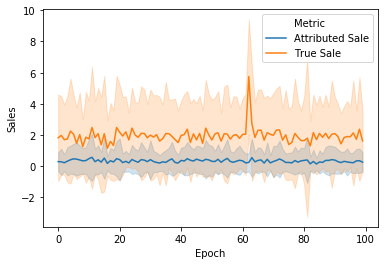

In [198]:
t0=datetime.now()
agent.train(n_trajectories=n_users, n_update=n_updates)
print('Number of users : ',n_users)
print('Number of updates : ',n_updates)

# Save the model
datetag = datetime.now().strftime("%d%m%Y-%H%M%S")
PATH = f"data/RL/PseuRein_{n_users}_{n_updates}_{datetag}.pth"
print(PATH)
torch.save(agent.model.state_dict(), PATH)
# agent.model.state_dict = torch.load(PATH)
t1=datetime.now()
print(t1-t0)

In [199]:
pkl.dump(agent.rewards,open(f'data/RL/PseuRein_att_{n_users}_{n_updates}_{datetag}.pkl','wb'))
pkl.dump(agent.true_rewards,open(f'data/RL/PseuRein_true_{n_users}_{n_updates}_{datetag}.pkl','wb'))

Loss: 12.966020686972652

Episode 1/100:
------ Attributed metrics
- Average attributed sales 0.25 +/- 0.69
- Total attributed sales 126.0
- Attributed CR 0.164
------ True metrics
- Average true sales 1.41 +/- 2.34
- Total true sales 707.0
- True CR 0.654
Loss: 13.133676867520116

Episode 2/100:
------ Attributed metrics
- Average attributed sales 0.28 +/- 0.76
- Total attributed sales 142.0
- Attributed CR 0.174
------ True metrics
- Average true sales 1.93 +/- 3.44
- Total true sales 963.25
- True CR 1.0
Loss: 13.409987645477845

Episode 3/100:
------ Attributed metrics
- Average attributed sales 0.34 +/- 0.8
- Total attributed sales 168.0
- Attributed CR 0.218
------ True metrics
- Average true sales 2.65 +/- 2.57
- Total true sales 1324.0
- True CR 1.0
Loss: 13.050553043788774

Episode 4/100:
------ Attributed metrics
- Average attributed sales 0.3 +/- 0.73
- Total attributed sales 149.0
- Attributed CR 0.192
------ True metrics
- Average true sales 2.22 +/- 4.19
- Total true sale

Loss: 14.49439772998964

Episode 33/100:
------ Attributed metrics
- Average attributed sales 0.31 +/- 0.74
- Total attributed sales 156.0
- Attributed CR 0.202
------ True metrics
- Average true sales 1.57 +/- 2.45
- Total true sales 785.0
- True CR 0.998
Loss: 17.682639933149016

Episode 34/100:
------ Attributed metrics
- Average attributed sales 0.36 +/- 0.86
- Total attributed sales 181.0
- Attributed CR 0.212
------ True metrics
- Average true sales 1.88 +/- 2.69
- Total true sales 940.0
- True CR 0.606
Loss: 11.357485890887434

Episode 35/100:
------ Attributed metrics
- Average attributed sales 0.26 +/- 0.66
- Total attributed sales 131.0
- Attributed CR 0.174
------ True metrics
- Average true sales 1.47 +/- 2.4
- Total true sales 736.0
- True CR 0.988
Loss: 13.252067234060059

Episode 36/100:
------ Attributed metrics
- Average attributed sales 0.36 +/- 1.04
- Total attributed sales 181.0
- Attributed CR 0.188
------ True metrics
- Average true sales 7.48 +/- 18.79
- Total tr

Loss: 14.586185628620408

Episode 65/100:
------ Attributed metrics
- Average attributed sales 0.32 +/- 0.79
- Total attributed sales 160.0
- Attributed CR 0.192
------ True metrics
- Average true sales 2.23 +/- 2.59
- Total true sales 1114.0
- True CR 0.814
Loss: 11.137535770117358

Episode 66/100:
------ Attributed metrics
- Average attributed sales 0.3 +/- 0.82
- Total attributed sales 151.0
- Attributed CR 0.176
------ True metrics
- Average true sales 1.57 +/- 2.91
- Total true sales 786.07
- True CR 0.542
Loss: 14.038612279193242

Episode 67/100:
------ Attributed metrics
- Average attributed sales 0.31 +/- 0.85
- Total attributed sales 157.0
- Attributed CR 0.176
------ True metrics
- Average true sales 1.63 +/- 2.29
- Total true sales 817.0
- True CR 0.604
Loss: 14.945644091442425

Episode 68/100:
------ Attributed metrics
- Average attributed sales 0.32 +/- 0.84
- Total attributed sales 159.0
- Attributed CR 0.18
------ True metrics
- Average true sales 1.7 +/- 2.54
- Total tr

C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 11.65124462583759

Episode 90/100:
------ Attributed metrics
- Average attributed sales 0.25 +/- 0.72
- Total attributed sales 123.0
- Attributed CR 0.162
------ True metrics
- Average true sales nan +/- nan
- Total true sales nan
- True CR 0.0


C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 14.823015746191544

Episode 91/100:
------ Attributed metrics
- Average attributed sales 0.3 +/- 0.79
- Total attributed sales 148.0
- Attributed CR 0.17
------ True metrics
- Average true sales nan +/- nan
- Total true sales nan
- True CR 0.0


C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 12.444765033297449

Episode 92/100:
------ Attributed metrics
- Average attributed sales 0.3 +/- 0.74
- Total attributed sales 152.0
- Attributed CR 0.214
------ True metrics
- Average true sales 1.63 +/- 2.46
- Total true sales 815.0
- True CR 0.562
Loss: 16.47867718374651

Episode 93/100:
------ Attributed metrics
- Average attributed sales 0.35 +/- 0.9
- Total attributed sales 173.0
- Attributed CR 0.192
------ True metrics
- Average true sales 1.72 +/- 2.47
- Total true sales 862.0
- True CR 1.0
Loss: 12.161949700429656

Episode 94/100:
------ Attributed metrics
- Average attributed sales 0.27 +/- 0.73
- Total attributed sales 137.0
- Attributed CR 0.168
------ True metrics
- Average true sales 2.32 +/- 2.16
- Total true sales 1159.0
- True CR 1.0
Loss: 13.99118383893194

Episode 95/100:
------ Attributed metrics
- Average attributed sales 0.3 +/- 0.77
- Total attributed sales 150.0
- Attributed CR 0.186
------ True metrics
- Average true sales 1.7 +/- 2.51
- Total true sales

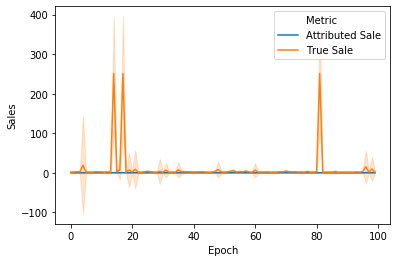

In [211]:
agent = PseudoREINFORCE(config,env,UserFeatures,RewardTilde)
n_users = 500
n_updates = 100
t0=datetime.now()
agent.train(n_trajectories=n_users, n_update=n_updates)
print('Number of users : ',n_users)
print('Number of updates : ',n_updates)

# Save the model
datetag = datetime.now().strftime("%d%m%Y-%H%M%S")
PATH = f"data/RL/PseuRein_{n_users}_{n_updates}_{datetag}.pth"
print(PATH)
torch.save(agent.model.state_dict(), PATH)
# agent.model.state_dict = torch.load(PATH)
t1=datetime.now()
print(t1-t0)

In [212]:
pkl.dump(agent.rewards,open(f'data/RL/PseuRein_att_{n_users}_{n_updates}_{datetag}.pkl','wb'))
pkl.dump(agent.true_rewards,open(f'data/RL/PseuRein_true_{n_users}_{n_updates}_{datetag}.pkl','wb'))

In [ ]:
t0=datetime.now()
agent.train(n_trajectories=n_users, n_update=n_updates)
print('Number of users : ',n_users)
print('Number of updates : ',n_updates)

# Save the model
datetag = datetime.now().strftime("%d%m%Y-%H%M%S")
PATH = f"data/RL/PseuRein_{n_users}_{n_updates}_{datetag}.pth"
print(PATH)
torch.save(agent.model.state_dict(), PATH)
# agent.model.state_dict = torch.load(PATH)
t1=datetime.now()
print(t1-t0)

Loss: 10.591514269286614

Episode 1/100:
------ Attributed metrics
- Average attributed sales 0.27 +/- 0.72
- Total attributed sales 133.0
- Attributed CR 0.164
------ True metrics
- Average true sales nan +/- nan
- Total true sales nan
- True CR 0.998


C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 15.376951435287019

Episode 2/100:
------ Attributed metrics
- Average attributed sales 0.37 +/- 0.83
- Total attributed sales 183.0
- Attributed CR 0.218
------ True metrics
- Average true sales 1.77 +/- 2.47
- Total true sales 886.0
- True CR 1.0
Loss: 13.76301129556186

Episode 3/100:
------ Attributed metrics
- Average attributed sales 0.34 +/- 0.83
- Total attributed sales 171.0
- Attributed CR 0.202
------ True metrics
- Average true sales 2.77 +/- 22.5
- Total true sales 1386.0
- True CR 1.0
Loss: 12.774960273805554

Episode 4/100:
------ Attributed metrics
- Average attributed sales 0.3 +/- 0.8
- Total attributed sales 148.0
- Attributed CR 0.172
------ True metrics
- Average true sales 1.81 +/- 2.61
- Total true sales 906.0
- True CR 0.612
Loss: 12.909826493356961

Episode 5/100:
------ Attributed metrics
- Average attributed sales 0.3 +/- 0.78
- Total attributed sales 150.0
- Attributed CR 0.182
------ True metrics
- Average true sales 8.35 +/- 21.52
- Total true sales 

Loss: 15.851591359306466

Episode 34/100:
------ Attributed metrics
- Average attributed sales 0.36 +/- 0.88
- Total attributed sales 179.0
- Attributed CR 0.21
------ True metrics
- Average true sales 123.88 +/- 950.83
- Total true sales 61939.27
- True CR 1.0
Loss: 13.027140342505165

Episode 35/100:
------ Attributed metrics
- Average attributed sales 0.32 +/- 0.83
- Total attributed sales 158.0
- Attributed CR 0.17
------ True metrics
- Average true sales 1.56 +/- 2.53
- Total true sales 782.0
- True CR 0.53
Loss: 15.038339984374447

Episode 36/100:
------ Attributed metrics
- Average attributed sales 0.32 +/- 0.89
- Total attributed sales 162.0
- Attributed CR 0.186
------ True metrics
- Average true sales 1.49 +/- 2.16
- Total true sales 745.0
- True CR 1.0
Loss: 15.20490396525523

Episode 37/100:
------ Attributed metrics
- Average attributed sales 0.33 +/- 0.75
- Total attributed sales 164.0
- Attributed CR 0.21
------ True metrics
- Average true sales 2.47 +/- 5.07
- Total tru

C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 14.839393805462349

Episode 45/100:
------ Attributed metrics
- Average attributed sales 0.32 +/- 0.86
- Total attributed sales 161.0
- Attributed CR 0.176
------ True metrics
- Average true sales 1.79 +/- 2.46
- Total true sales 893.0
- True CR 0.626
Loss: 14.019867994227683

Episode 46/100:
------ Attributed metrics
- Average attributed sales 0.3 +/- 0.7
- Total attributed sales 148.0
- Attributed CR 0.206
------ True metrics
- Average true sales 1.81 +/- 2.56
- Total true sales 904.0
- True CR 0.602
Loss: 14.750213910019088

Episode 47/100:
------ Attributed metrics
- Average attributed sales 0.29 +/- 0.78
- Total attributed sales 145.0
- Attributed CR 0.174
------ True metrics
- Average true sales 8.25 +/- 25.28
- Total true sales 4126.57
- True CR 1.0
Loss: 12.320670858108661

Episode 48/100:
------ Attributed metrics
- Average attributed sales 0.3 +/- 0.77
- Total attributed sales 150.0
- Attributed CR 0.178
------ True metrics
- Average true sales 9.77 +/- 25.28
- Total tr

Loss: 14.874012883722532

Episode 1/100:
------ Attributed metrics
- Average attributed sales 0.34 +/- 0.81
- Total attributed sales 171.0
- Attributed CR 0.198
------ True metrics
- Average true sales nan +/- nan
- Total true sales nan
- True CR 0.996


C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 13.843870299212806

Episode 2/100:
------ Attributed metrics
- Average attributed sales 0.3 +/- 0.79
- Total attributed sales 150.0
- Attributed CR 0.186
------ True metrics
- Average true sales 1.82 +/- 2.72
- Total true sales 908.0
- True CR 0.614
Loss: 15.892046850751237

Episode 3/100:
------ Attributed metrics
- Average attributed sales 0.38 +/- 0.87
- Total attributed sales 188.0
- Attributed CR 0.218
------ True metrics
- Average true sales 1.83 +/- 2.54
- Total true sales 915.0
- True CR 0.606
Loss: 15.89946131870019

Episode 4/100:
------ Attributed metrics
- Average attributed sales 0.33 +/- 0.88
- Total attributed sales 165.0
- Attributed CR 0.178
------ True metrics
- Average true sales 3.25 +/- 3.52
- Total true sales 1626.0
- True CR 0.786
Loss: 13.449338332423439

Episode 5/100:
------ Attributed metrics
- Average attributed sales 0.31 +/- 0.84
- Total attributed sales 155.0
- Attributed CR 0.178
------ True metrics
- Average true sales 4.76 +/- 4.31
- Total true s

C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 12.195035842383787

Episode 14/100:
------ Attributed metrics
- Average attributed sales 0.28 +/- 0.73
- Total attributed sales 138.0
- Attributed CR 0.174
------ True metrics
- Average true sales nan +/- nan
- Total true sales nan
- True CR 0.8


C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 12.436491316373463

Episode 15/100:
------ Attributed metrics
- Average attributed sales 0.3 +/- 0.74
- Total attributed sales 150.0
- Attributed CR 0.19
------ True metrics
- Average true sales 1.78 +/- 2.45
- Total true sales 891.0
- True CR 0.584
Loss: 11.087909369872106

Episode 16/100:
------ Attributed metrics
- Average attributed sales 0.25 +/- 0.74
- Total attributed sales 125.0
- Attributed CR 0.146
------ True metrics
- Average true sales 1.71 +/- 2.55
- Total true sales 854.0
- True CR 0.558
Loss: 14.1885683150169

Episode 17/100:
------ Attributed metrics
- Average attributed sales 0.34 +/- 0.83
- Total attributed sales 168.0
- Attributed CR 0.198
------ True metrics
- Average true sales 249.04 +/- 144.5
- Total true sales 124521.0
- True CR 0.996
Loss: 14.555786617622024

Episode 18/100:
------ Attributed metrics
- Average attributed sales 0.31 +/- 0.77
- Total attributed sales 153.0
- Attributed CR 0.174
------ True metrics
- Average true sales 1.36 +/- 2.3
- Total 

Loss: 14.861303967892235

Episode 47/100:
------ Attributed metrics
- Average attributed sales 0.36 +/- 0.88
- Total attributed sales 182.0
- Attributed CR 0.202
------ True metrics
- Average true sales 2.21 +/- 2.73
- Total true sales 1103.0
- True CR 0.754
Loss: 14.332940971287654

Episode 48/100:
------ Attributed metrics
- Average attributed sales 0.32 +/- 0.84
- Total attributed sales 162.0
- Attributed CR 0.192
------ True metrics
- Average true sales -0.71 +/- 2.5
- Total true sales -357.01
- True CR 0.22
Loss: 17.081329917086173

Episode 49/100:
------ Attributed metrics
- Average attributed sales 0.41 +/- 0.91
- Total attributed sales 206.0
- Attributed CR 0.24
------ True metrics
- Average true sales 1.04 +/- 3.78
- Total true sales 521.99
- True CR 0.462
Loss: 15.007437436167072

Episode 50/100:
------ Attributed metrics
- Average attributed sales 0.32 +/- 0.76
- Total attributed sales 159.0
- Attributed CR 0.206
------ True metrics
- Average true sales 1.6 +/- 2.48
- Total 

C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 16.97381579078234

Episode 57/100:
------ Attributed metrics
- Average attributed sales 0.36 +/- 0.9
- Total attributed sales 179.0
- Attributed CR 0.196
------ True metrics
- Average true sales 250.98 +/- 144.37
- Total true sales 125488.0
- True CR 0.998
Loss: 14.835681065747865

Episode 58/100:
------ Attributed metrics
- Average attributed sales 0.31 +/- 0.78
- Total attributed sales 155.0
- Attributed CR 0.202
------ True metrics
- Average true sales 3.53 +/- 31.49
- Total true sales 1765.0
- True CR 0.514
Loss: 12.204493160997886

Episode 59/100:
------ Attributed metrics
- Average attributed sales 0.26 +/- 0.66
- Total attributed sales 130.0
- Attributed CR 0.172
------ True metrics
- Average true sales 1.55 +/- 2.15
- Total true sales 776.0
- True CR 1.0
Loss: 15.219435002257608

Episode 60/100:
------ Attributed metrics
- Average attributed sales 0.34 +/- 0.78
- Total attributed sales 169.0
- Attributed CR 0.208
------ True metrics
- Average true sales 249.05 +/- 144.48


C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 15.075865623010243

Episode 62/100:
------ Attributed metrics
- Average attributed sales 0.35 +/- 0.94
- Total attributed sales 176.0
- Attributed CR 0.2
------ True metrics
- Average true sales 251.09 +/- 144.22
- Total true sales 125546.0
- True CR 0.998
Loss: 12.570548323386932

Episode 63/100:
------ Attributed metrics
- Average attributed sales 0.27 +/- 0.72
- Total attributed sales 135.0
- Attributed CR 0.168
------ True metrics
- Average true sales 250.95 +/- 144.21
- Total true sales 125475.0
- True CR 0.998
Loss: 14.786292427978031

Episode 64/100:
------ Attributed metrics
- Average attributed sales 0.38 +/- 1.11
- Total attributed sales 189.0
- Attributed CR 0.182
------ True metrics
- Average true sales 2.16 +/- 3.38
- Total true sales 1080.55
- True CR 1.0
Loss: 13.279736242534904

Episode 65/100:
------ Attributed metrics
- Average attributed sales 0.29 +/- 0.68
- Total attributed sales 147.0
- Attributed CR 0.2
------ True metrics
- Average true sales nan +/- nan
-

C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 10.681677753148067

Episode 66/100:
------ Attributed metrics
- Average attributed sales 0.26 +/- 0.71
- Total attributed sales 132.0
- Attributed CR 0.168
------ True metrics
- Average true sales nan +/- nan
- Total true sales nan
- True CR 0.0


C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 16.096486108987094

Episode 67/100:
------ Attributed metrics
- Average attributed sales 0.35 +/- 0.81
- Total attributed sales 173.0
- Attributed CR 0.212
------ True metrics
- Average true sales 251.12 +/- 144.26
- Total true sales 125558.0
- True CR 1.0
Loss: 15.826087410371692

Episode 68/100:
------ Attributed metrics
- Average attributed sales 0.35 +/- 0.88
- Total attributed sales 174.0
- Attributed CR 0.192
------ True metrics
- Average true sales 20811.13 +/- 18648.74
- Total true sales 10405566.27
- True CR 1.0
Loss: 14.722284886080878

Episode 69/100:
------ Attributed metrics
- Average attributed sales 0.33 +/- 0.83
- Total attributed sales 164.0
- Attributed CR 0.192
------ True metrics
- Average true sales 347775678.64 +/- 376625895.34
- Total true sales 173887839321.3
- True CR 1.0
Loss: 12.976717935188104

Episode 70/100:
------ Attributed metrics
- Average attributed sales 0.32 +/- 0.79
- Total attributed sales 160.0
- Attributed CR 0.18
------ True metrics
- Ave

C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater


Loss: 12.441263008631031

Episode 77/100:
------ Attributed metrics
- Average attributed sales 0.28 +/- 0.77
- Total attributed sales 138.0
- Attributed CR 0.16
------ True metrics
- Average true sales 1.77 +/- 2.49
- Total true sales 885.0
- True CR 0.568
Loss: 13.241433023941932

Episode 78/100:
------ Attributed metrics
- Average attributed sales 0.31 +/- 0.84
- Total attributed sales 155.0
- Attributed CR 0.172
------ True metrics
- Average true sales 1.74 +/- 2.51
- Total true sales 872.0
- True CR 0.574
Loss: 15.28170149341495

Episode 79/100:
------ Attributed metrics
- Average attributed sales 0.34 +/- 0.84
- Total attributed sales 168.0
- Attributed CR 0.206
------ True metrics
- Average true sales 1.71 +/- 2.4
- Total true sales 855.0
- True CR 0.6
Loss: 14.246963517027673

Episode 80/100:
------ Attributed metrics
- Average attributed sales 0.33 +/- 0.81
- Total attributed sales 164.0
- Attributed CR 0.194
------ True metrics
- Average true sales 251.05 +/- 144.15
- Total tr

C:\Users\Philo\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Loss: 16.1910743865252

Episode 89/100:
------ Attributed metrics
- Average attributed sales 0.35 +/- 0.92
- Total attributed sales 175.0
- Attributed CR 0.206
------ True metrics
- Average true sales 2.15 +/- 3.82
- Total true sales 1074.8
- True CR 1.0
Loss: 14.761644567423263

Episode 90/100:
------ Attributed metrics
- Average attributed sales 0.33 +/- 0.87
- Total attributed sales 167.0
- Attributed CR 0.196
------ True metrics
- Average true sales 2.61 +/- 2.47
- Total true sales 1307.0
- True CR 1.0
Loss: 15.398980462957656

Episode 91/100:
------ Attributed metrics
- Average attributed sales 0.34 +/- 0.82
- Total attributed sales 170.0
- Attributed CR 0.21
------ True metrics
- Average true sales 1.82 +/- 2.65
- Total true sales 912.0
- True CR 1.0
Loss: 15.827727387375933

Episode 92/100:
------ Attributed metrics
- Average attributed sales 0.37 +/- 0.92
- Total attributed sales 186.0
- Attributed CR 0.212
------ True metrics
- Average true sales 1.76 +/- 2.62
- Total true sal

C:\Users\Philo\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Loss: 14.415610069050636

Episode 100/100:
------ Attributed metrics
- Average attributed sales 0.32 +/- 0.72
- Total attributed sales 160.0
- Attributed CR 0.21
------ True metrics
- Average true sales 1.9 +/- 2.86
- Total true sales 949.2
- True CR 1.0
Number of users :  500
Number of updates :  100
data/RL/PseuRein_500_100_02102020-215011.pth
9:05:41.663358


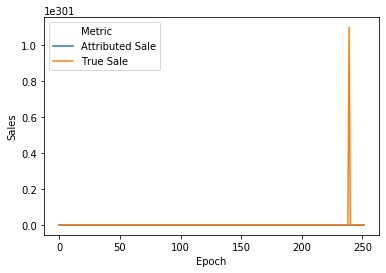

In [215]:
t0=datetime.now()
agent.train(n_trajectories=n_users, n_update=n_updates)
print('Number of users : ',n_users)
print('Number of updates : ',n_updates)

# Save the model
datetag = datetime.now().strftime("%d%m%Y-%H%M%S")
PATH = f"data/RL/PseuRein_{n_users}_{n_updates}_{datetag}.pth"
print(PATH)
torch.save(agent.model.state_dict(), PATH)
# agent.model.state_dict = torch.load(PATH)
t1=datetime.now()
print(t1-t0)

In [216]:
pkl.dump(agent.rewards,open(f'data/RL/PseuRein_att_{n_users}_{n_updates}_{datetag}.pkl','wb'))
pkl.dump(agent.true_rewards,open(f'data/RL/PseuRein_true_{n_users}_{n_updates}_{datetag}.pkl','wb'))

In [ ]:
t0=datetime.now()
agent.train(n_trajectories=n_users, n_update=n_updates)
print('Number of users : ',n_users)
print('Number of updates : ',n_updates)

# Save the model
datetag = datetime.now().strftime("%d%m%Y-%H%M%S")
PATH = f"data/RL/PseuRein_{n_users}_{n_updates}_{datetag}.pth"
print(PATH)
torch.save(agent.model.state_dict(), PATH)
# agent.model.state_dict = torch.load(PATH)
t1=datetime.now()
print(t1-t0)

In [ ]:
pkl.dump(agent.rewards,open(f'data/RL/PseuRein_att_{n_users}_{n_updates}_{datetag}.pkl','wb'))
pkl.dump(agent.true_rewards,open(f'data/RL/PseuRein_true_{n_users}_{n_updates}_{datetag}.pkl','wb'))